<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Reading-McStas-data" data-toc-modified-id="Reading-McStas-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reading McStas data</a></span><ul class="toc-item"><li><span><a href="#Read-the-data." data-toc-modified-id="Read-the-data.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Read the data.</a></span></li><li><span><a href="#Reducing-size-of--data-set" data-toc-modified-id="Reducing-size-of--data-set-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Reducing size of  data set</a></span></li><li><span><a href="#Using-seaborn-for-plotting" data-toc-modified-id="Using-seaborn-for-plotting-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Using seaborn for plotting</a></span></li></ul></li><li><span><a href="#Converting-to-integer-events---Kernel-density-estimation" data-toc-modified-id="Converting-to-integer-events---Kernel-density-estimation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Converting to integer events - Kernel density estimation</a></span></li><li><span><a href="#Discrete-distribution" data-toc-modified-id="Discrete-distribution-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Discrete distribution</a></span></li><li><span><a href="#Continous-distribution" data-toc-modified-id="Continous-distribution-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Continous distribution</a></span><ul class="toc-item"><li><span><a href="#What-we-will-do" data-toc-modified-id="What-we-will-do-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>What we will do</a></span></li><li><span><a href="#Create-some-artificial-weighted-data" data-toc-modified-id="Create-some-artificial-weighted-data-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Create some artificial weighted data</a></span></li><li><span><a href="#Trimodal-distribution" data-toc-modified-id="Trimodal-distribution-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Trimodal distribution</a></span></li></ul></li><li><span><a href="#Fitting" data-toc-modified-id="Fitting-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Fitting</a></span></li><li><span><a href="#Kernel-density-estimation" data-toc-modified-id="Kernel-density-estimation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Kernel density estimation</a></span></li></ul></div>

# Event based data analysis

## Introduction
In this notebook we will try to analyse data for single crystal diffraction without converting events to histogram

We will test the approach on single crystal diffraction data, and rather than using real data we will use data generated by McStas. We therefore first need to convert McStas' concept of 'neutron flux events' to integer events, where each event represent the detection of single neutron as in a real experiment.

## Reading McStas data
We will use pandas to read in McStas data. pandas can read both csv / ascii file and hdf5 file. In this case, we will read an ascii file.

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib inline
import pandas
sx_csv_filename = '../pkw_data/Single_crystal_VE/HDFoutput_quick_ascii/bank01_events_dat_list.p.x.y.n.id.t.gz'

### Read the data. 
The columns are described in line 54 as p, x, y, n, id, t, which translate to:
intensity (or weight), x, y, counter, pixel id, time-of-flight (tof). The actual data start on line 56. 
Columns are seperated with a space

In [5]:
data_mcstas = pandas.read_csv(sx_csv_filename, sep='\s+', skiprows=55, header=None, 
                  names=['intensity', 'x', 'y', '#n', '#pixel', 'tof'])  # intensity is really neutrons per second for the given pixel

Let's take a look at the data

In [6]:
data_mcstas.head()

,intensity,x,y,#n,#pixel,tof
0,3.677209,0.199655,-0.091125,0,5738,0.087696
1,20.490947,0.004518,0.255857,1,15168,0.088790
2,1.017154,0.096992,0.075024,2,10324,0.088740
3,20.490947,0.004554,-0.255041,3,1216,0.088791
4,0.090111,0.098353,-0.075793,4,6100,0.091665


In [7]:
data_mcstas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94053 entries, 0 to 94052
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   intensity  94053 non-null  float64
 1   x          94053 non-null  float64
 2   y          94053 non-null  float64
 3   #n         94053 non-null  int64  
 4   #pixel     94053 non-null  int64  
 5   tof        94053 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 4.3 MB


In [8]:
data_mcstas.min()

intensity    5.515556e-47
x           -2.999833e-01
y           -2.999948e-01
#n           0.000000e+00
#pixel       3.700000e+01
tof          7.191995e-02
dtype: float64

In [8]:
data_mcstas.max()

intensity      807.220937
x                0.299986
y                0.299977
#n            8574.000000
#pixel       16371.000000
tof              0.100000
dtype: float64

Make 1 3D plot

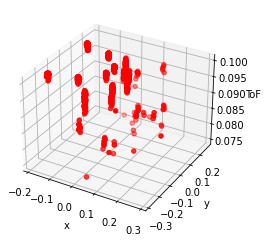

In [9]:
def plot3d(df):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(df['x'], df['y'], df['tof'], c='r', marker='o')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('ToF')

    plt.show()
    
plot3d(data_mcstas[data_mcstas['intensity']>50])

### Reducing size of  data set
As can be seen from above some data have weights which in practise are zero. Let's try to look at that in more detail in order to see if we can remove some 'neutron flux events' without harm

In [10]:
data_mcstas.sort_values(by='intensity', inplace=True, ascending=True)
data_mcstas['accumulated intensity'] = data_mcstas['intensity'].cumsum()

In [11]:
data_mcstas.head()

,intensity,x,y,#n,#pixel,tof,accumulated intensity
38894,5.515556e-47,0.078302,0.027866,127,8912,0.078307,5.515556e-47
52781,3.276648e-45,-0.075454,-0.190722,6183,2991,0.079545,3.331803e-45
52117,2.212714e-42,0.104924,-0.156882,5519,3926,0.086846,2.216046e-42
58680,2.098637e-40,-0.293602,-0.102483,4318,5377,0.079683,2.120797e-40
58679,4.128727e-40,0.045167,0.027815,4317,8905,0.079605,6.249524e-40


In [12]:
import numpy
counter = numpy.linspace(0, len(data_mcstas)-1, len(data_mcstas))

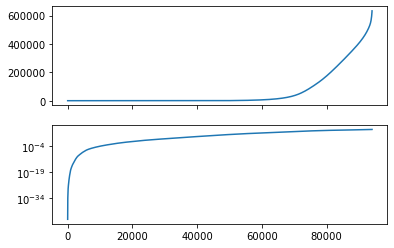

In [13]:
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
#plt.subplot(211)
ax1.plot(counter, data_mcstas['accumulated intensity'])
#plt.subplot(212)
ax2.semilogy(counter, data_mcstas['accumulated intensity'])

Looks like we can cut the 60000 thousand lowest values without much loss

In [14]:
data_mcstas.sort_values(by='intensity')['intensity'][60000:].sum()/data_mcstas['intensity'].sum()

0.9907439524922654

Thus, we loose less than 1% by cutting at 60000

Let's assume we are okay with loosing rays so that we loose 0.1% of the total flux

In [15]:
def get_reduced_dataset(data, preserve_fraction=0.999, weight_key='intensity', verbose=True):
    """
    Generates a data set with the minimum number of rays required to preserve 
    "preserve_fraction" flux from the total data set.
    """
    reduced_data = data.sort_values(by=weight_key, ascending=True)
    new_key = 'accumulated ' + weight_key
    reduced_data[new_key] = reduced_data[weight_key].cumsum()
    total_neutron_flux = data[weight_key].sum()
    cutoff_accumulated_value = (1.-preserve_fraction)*total_neutron_flux
    reduced_data = reduced_data[reduced_data[new_key] > cutoff_accumulated_value]
    total_reduced_flux = reduced_data[weight_key].sum()
    if verbose:
        print("Size of reduced data set is", len(reduced_data))
        print("Minimum weight included is {:.2}".format(reduced_data[weight_key].min()))
        print("Flux omitted is {:.3}".format(total_neutron_flux - total_reduced_flux))
        print("Total reduced flux {:.3}".format(total_reduced_flux))
    return reduced_data

In [16]:
data_reduced = get_reduced_dataset(data_mcstas, preserve_fraction=0.999)

Size of reduced data set is 44715
Minimum weight included is 0.16
Flux omitted is 6.33e+02
Total reduced flux 6.33e+05


Thus, we can get down to less than 1 promille loss by keeping a few data more

In [17]:
data_reduced.head()

,intensity,x,y,#n,#pixel,tof,accumulated intensity
42085,0.159459,-0.015814,0.060345,3318,9788,0.081557,633.585657
71961,0.159732,0.233120,0.175442,1866,13041,0.097911,633.745389
71964,0.159732,0.231302,0.177024,1869,13041,0.097911,633.905121
71963,0.159732,0.233122,-0.185894,1868,3185,0.097913,634.064853
71960,0.159732,0.233001,-0.183717,1865,3185,0.097912,634.224586


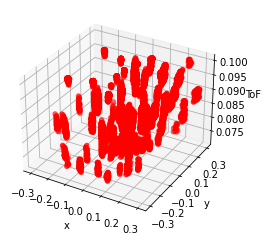

In [18]:
plot3d(data_reduced)

### Using seaborn for plotting
As a sidenote

In [20]:
import seaborn
import numpy

In [21]:
data_reduced['color'] = data_reduced['intensity'].apply(lambda x: int(numpy.log(x)))
data_reduced.head()

,intensity,x,y,#n,#pixel,tof,accumulated intensity,color
42085,0.159459,-0.015814,0.060345,3318,9788,0.081557,633.585657,-1
71961,0.159732,0.233120,0.175442,1866,13041,0.097911,633.745389,-1
71964,0.159732,0.231302,0.177024,1869,13041,0.097911,633.905121,-1
71963,0.159732,0.233122,-0.185894,1868,3185,0.097913,634.064853,-1
71960,0.159732,0.233001,-0.183717,1865,3185,0.097912,634.224586,-1


/Users/thomasholmrod/opt/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


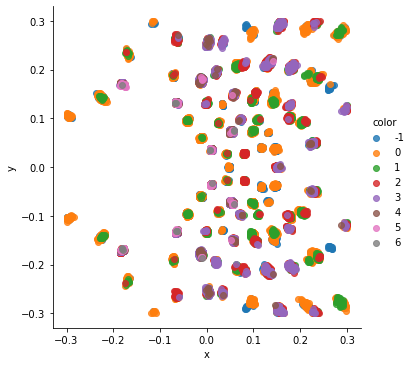

In [22]:
sea_plot = seaborn.lmplot('x', 'y', data=data_reduced, hue='color', fit_reg=False)

/Users/thomasholmrod/opt/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


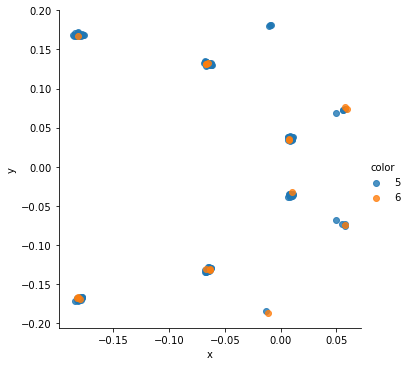

In [23]:
sea_plot = seaborn.lmplot('x', 'y', data=data_reduced[data_reduced['intensity']>200], hue='color', fit_reg=False)

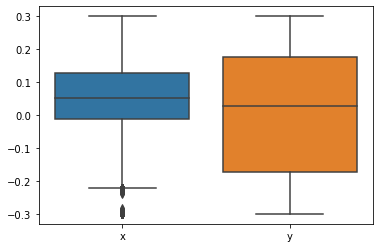

In [24]:
sea_hist = seaborn.boxplot(data=data_reduced[['x','y']])

## Converting to integer events - Kernel density estimation

There are (at least) two approaches:
1. **Discrete distribution**. If we are happy with only having events in the McStas detected time-space points (i.e. discrete sampling), we can make a weighted choice among the McStas events using e.g. the PanDaaS sample method: http://pandas.pydata.org/pandas-docs/version/0.19/generated/pandas.DataFrame.sample.html
2. **Continous distribution**. If we want a continous distribution of intenger events from the McStas 'neutron flux event' data, we center a gaussian on each event, i.e. on (x,y,tof) and with integral (norm) of the intensity. This corresponds to performing a Kernel Density Estimation using gaussians as kernel. Several modules provide methods for performing Kernel Density Estimation (e.g. scipy, scikit-learn, statsmodels, and rqkit, but usualy only in one dimention and usually only for data that are not weighted. There exist a snippet where KDE is implemented for multi-variate weighted data at this link: 

## Discrete distribution
`DataFrame.sample(n=None, frac=None, replace=False, weights=None, random_state=None, axis=None)`

In [25]:
data_reduced.head()

,intensity,x,y,#n,#pixel,tof,accumulated intensity,color
42085,0.159459,-0.015814,0.060345,3318,9788,0.081557,633.585657,-1
71961,0.159732,0.233120,0.175442,1866,13041,0.097911,633.745389,-1
71964,0.159732,0.231302,0.177024,1869,13041,0.097911,633.905121,-1
71963,0.159732,0.233122,-0.185894,1868,3185,0.097913,634.064853,-1
71960,0.159732,0.233001,-0.183717,1865,3185,0.097912,634.224586,-1


In [26]:
xyt = data_reduced[ ['x', 'y', 'tof'] ]

In [27]:
xyt_sample2 = xyt.sample(n=100, replace=True, weights=data_reduced['intensity'], random_state=0)
xyt_sample2.head()

,x,y,tof
45568,-0.011551,-0.178222,0.095542
88742,-0.015260,-0.179064,0.094371
89041,0.052883,0.071378,0.094319
32412,0.022219,-0.192865,0.079950
15233,0.050809,-0.073814,0.094397


In [28]:
xyt_sample2a = data_reduced.sample(n=100, replace=True, weights='intensity', random_state=0)[ ['x', 'y', 'tof']]
xyt_sample2a.head()

,x,y,tof
45568,-0.011551,-0.178222,0.095542
88742,-0.015260,-0.179064,0.094371
89041,0.052883,0.071378,0.094319
32412,0.022219,-0.192865,0.079950
15233,0.050809,-0.073814,0.094397


In [29]:
xyt_sample6 = xyt.sample(n=10**6, replace=True, weights=data_reduced['intensity'], random_state=0)

<AxesSubplot:ylabel='Density'>

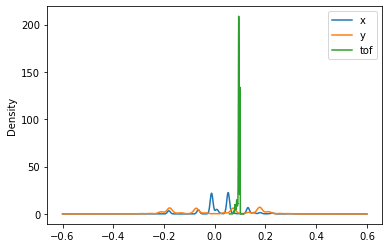

In [30]:
xyt_sample6.plot.density()

<AxesSubplot:ylabel='Density'>

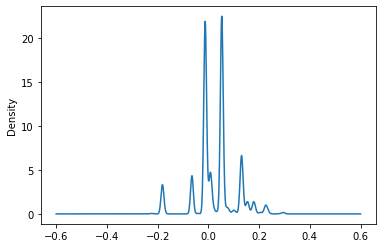

In [31]:
xyt_sample6['x'].plot.density()

<AxesSubplot:ylabel='Density'>

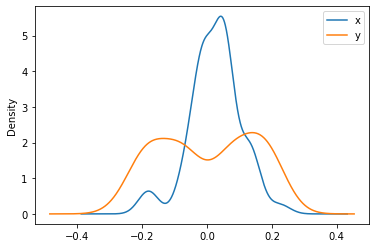

In [32]:
xyt_sample2[['x','y']].plot.density()

## Continous distribution
### What we will do
What we will do here, in order to keep track of what we doing, is that we will implement our own multivariate KDE for 
weighted data and find the optimal bandwidth by using k-means cross-validation or leave-one-out procedure.  

### Create some artificial weighted data

Create a bimodal distribution, using statsmodels. Various distributions are implemented in many modules (e.g. scipy.stat.distributions), and some modules also implement methods for combining distributions. Here we will use statsmodels, there also seem to have better coverage of multivariate models.

In [33]:
from scipy.stats import distributions as dbs
from scipy import stats

In [43]:
class multimodal(stats.rv_continuous):
    def __init__(self, distributions, weights):
        self.distributions = distributions
        # normalize weights
        self.set_weights(weights)
    
    def pdf(self, x, normalize_in_range=False):
        """
        Returns the probability distribution function calculated at the values of x.
        """
        pdfs = self.get_pdfs(x)
        if pdfs.ndim == 1:
            return pdfs[-1]
        else:
            return pdfs[:,-1]
    
    def get_pdfs(self, x):
        """
        Returns a list of pdfs one for each distribution and with the sum as the last item
        """
        pdfs = numpy.array([distribution.pdf(x) for distribution in self.distributions]).T
        pdfs *= self.weights
        if pdfs.ndim == 1: # in case x is not an array
            pdf_sum = pdfs.sum()
            return numpy.append(pdfs, pdf_sum)
        else:
            pdf_sum = pdfs.sum(axis=1)
            return numpy.append(pdfs, pdf_sum[:,None], axis=1)
    
    def rvs(self, npoints=1, xmin=None, xmax=None):
        """
        Return npoints of the variates. Values outside the range [xmin, xmax] will be 
        filtered out if xmin and / or xmax is defined
        """
        # Find numbers of selections from each distribution
        picks = numpy.random.choice(range(len(self.weights)), npoints, p=self.weights)
        npicks = numpy.bincount(picks)
        rvss = [distribution.rvs(n) for distribution, n in zip(self.distributions, npicks)]
        _rvs = numpy.concatenate(rvss)
        if xmin != None:
            _rvs = _rvs[_rvs >= xmin]
        if xmax != None:
            _rvs = _rvs[_rvs <= xmax]
        numpy.random.shuffle(_rvs)
        return _rvs
        
    def set_weights(self, weights):
        self.weights = numpy.asarray(weights)/numpy.sum(weights)
        
    def plot(self, xmin=-5., xmax=5., npoints=200):
        x = numpy.linspace(xmin, xmax, npoints)
        pdfs = self.get_pdfs(x)
        plt.plot(x, pdfs)
        
    def plot_sum(self, xmin=-5., xmax=5., npoints=100):
        x = numpy.linspace(xmin, xmax, npoints)
        plt.plot(x, self.pdf(x))

In [44]:
from statsmodels.distributions.mixture_rvs import mixture_rvs
# Using statsmodels
#obs_dist1 = mixture_rvs([.25,.75], size=10000, dist=[stats.norm, stats.norm],
#                kwargs = (dict(loc=-1,scale=.5),dict(loc=1,scale=.5)))


### Trimodal distribution
Let's define three signals; a Lorentzian (Cauchy), and two Gaussians on top of each other, plus some background composed of a constant offset plus an constantly increasing offset.

In [45]:
cauchy = dbs.cauchy(loc=-1., scale=1.)
norm1 = dbs.norm(loc=1., scale=0.4)
norm2 = dbs.norm(loc=1, scale=3.)
background1 = dbs.powerlaw(a=2., scale=13., loc=-7.)
distributions = [cauchy, norm1, norm2, background1] #, background2]

Background turned off

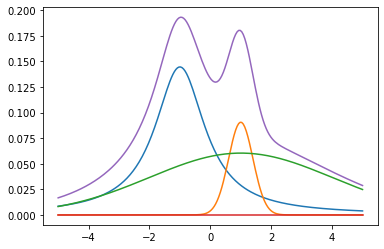

In [46]:
weights = [1., 0.2, 1., 0.]
trimodal = multimodal(distributions=distributions, weights=weights)
trimodal.plot()

Background turned on

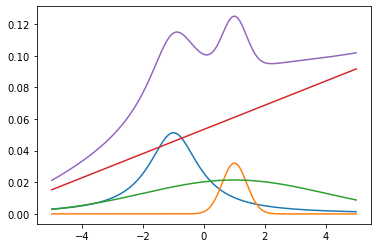

In [47]:
weights = [1., 0.2, 1., 4.]
trimodal.set_weights(weights)
trimodal.plot()

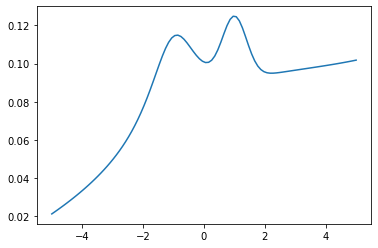

In [48]:
trimodal.plot_sum()

In [49]:
events = trimodal.rvs(10**6)

In [52]:
plt.hist?

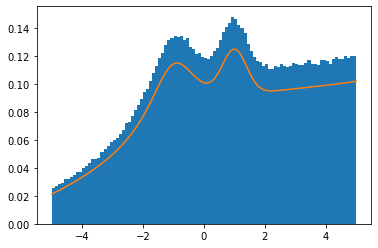

In [53]:
hist = plt.hist(events, density=True, range=(-5.,5.), bins=100)
x = numpy.linspace(-5., 5., 100)
pdf = trimodal.pdf(x)
plt.plot(x, pdf)

Seem's that the real distribution is constantly under the histogram!! Probably because histogram is normalized within the depicted range whereas the real pdf is normalized in the range $]-\infty:\infty[$.

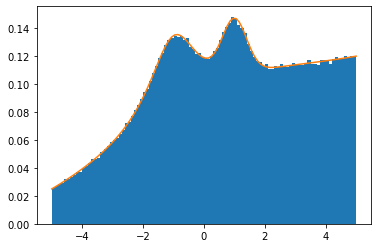

In [55]:
from scipy import integrate
integral = integrate.quad(trimodal.pdf, a=-5., b=5.)
pdf_norm = pdf/integral[0]
hist = plt.hist(events, density=True, range=(-5.,5.), bins=100)
plt.plot(x, pdf_norm)

There we go!

## Fitting
We will use lmfit for fitting. Let's try to fit to the 'real ideal' data, just to check that it works. If we cannot do this, we cannot expect to be able to handle real experimental data.

In [56]:
import lmfit

We can make use of lmfit's builtin models, but we note that lmfit has an advanced Model class for defining own models.

In [57]:
# We do not instantiate the classes yet, because we may need several instances of the same clas
lorentzian = lmfit.models.LorentzianModel
gaussian = lmfit.models.GaussianModel
background = lmfit.models.LinearModel

In [58]:
def modelmn(m_lor,n_gauss):
    """
    Returns a lmfit Model composed of a background, m Lorentzian and n Guassian models
    """
    lorentzians = [lorentzian(prefix='l{0}_'.format(i)) for i in range(m_lor)]
    gaussians = [gaussian(prefix='g{0}_'.format(i)) for i in range(n_gauss)]
    models = [background(prefix='b_')] + lorentzians + gaussians
    return numpy.sum(models) # Note that the builtin sum does not work here

In [59]:
model12 = modelmn(1,2) # model with background, 1 Lorentzian, and 1 Gaussians
print("\nIndependent variable is: '{0}'\n".format(model12.independent_vars[0]))
print("Fitable parameters are: '{0}'\n".format("', '".join(model12.param_names)))


Independent variable is: 'x'

Fitable parameters are: 'b_slope', 'b_intercept', 'l0_amplitude', 'l0_center', 'l0_sigma', 'g0_amplitude', 'g0_center', 'g0_sigma', 'g1_amplitude', 'g1_center', 'g1_sigma'



{'g1_amplitude': -527.5330698444757,
 'g1_center': -508.91203850336206,
 'g1_sigma': 1222.7935350111675,
 'g0_amplitude': -72.90258319094198,
 'g0_center': 825.7086141872476,
 'g0_sigma': 1598.9817152022888,
 'l0_amplitude': 0.603646883542885,
 'l0_center': -0.4046893756446099,
 'l0_sigma': 2.631850635073132,
 'b_slope': 0.008847025316189402,
 'b_intercept': 0.21709372563442325}

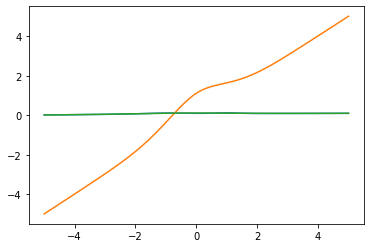

In [60]:
fit12 = model12.fit(pdf, x=x)
plt.plot(x, pdf)
plt.plot(x, fit12.init_fit)
plt.plot(x, fit12.best_fit)
fit12.best_values

This is a terrible fit. Let's look at the init values

In [61]:
fit12.init_values

{'g1_amplitude': 1.0,
 'g1_center': 0.0,
 'g1_sigma': 1.0,
 'g0_amplitude': 1.0,
 'g0_center': 0.0,
 'g0_sigma': 1.0,
 'l0_amplitude': 1.0,
 'l0_center': 0.0,
 'l0_sigma': 1.0,
 'b_slope': 1.0,
 'b_intercept': 0.0}

Note that the Gaussian is given by 
\begin{equation}
g(x; A, x_0, \sigma) = \frac{A}{\sigma\sqrt{2\pi}}\exp\left(-\frac{(x-x_0)^2}{2\sigma^2} \right)
\end{equation}
Thus, a higher value of $\sigma$ results in a broader Gaussian with lower peak height.

As can be seen all peak functions are placed on top of each other. Let's try to change the initial values and set boundary conditions. Let's first try to constrain the slope of the background.

{'g1_amplitude': 0.03225806471614684, 'g1_center': 1.0000000005347256, 'g1_sigma': 0.4000000010163278, 'g0_amplitude': 0.16129033029596315, 'g0_center': 1.000000052772013, 'g0_sigma': 3.000000084150111, 'l0_amplitude': 0.1612903236440853, 'l0_center': -0.9999999956194316, 'l0_sigma': 1.0000000027216092, 'b_slope': 0.007635044799377666, 'b_intercept': 0.05344531337912259}


/Users/thomasholmrod/opt/anaconda3/envs/ML/lib/python3.9/site-packages/lmfit/minimizer.py:484: RuntimeWarning: ignoring `maxfev` argument to `Minimizer()`. Use `max_nfev` instead.
  warnings.warn(MAXEVAL_Warning % (maxnfev_alias, 'Minimizer'),


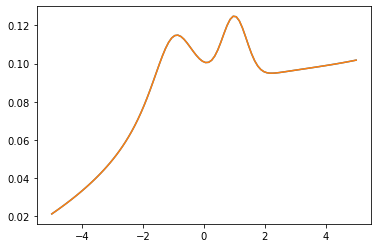

In [62]:
params = model12.make_params()
params['b_slope'].set(0.01, min=0.0, max=0.1) # it's important with a good start value here
params['l0_center'].set(-0.6, min=-1.5, max=-0.5)
params['g0_center'].set(0.7, min=0.5, max=1.5) 
params['g0_amplitude'].set(0.2) # set the one gaussian to be smaller than the other
params['g1_center'].set(1.2, min=0.5, max=1.5)
lmfit12_v2 = model12.fit(pdf, params, x=x, fit_kws={'maxfev':1000})
print(lmfit12_v2.best_values)
plt.plot(x, lmfit12_v2.best_fit, x, pdf)

Perfect fit with chi square of 0.000 as seen below!

In [63]:
print(lmfit12_v2.fit_report())

[[Model]]
    (((Model(linear, prefix='b_') + Model(lorentzian, prefix='l0_')) + Model(gaussian, prefix='g0_')) + Model(gaussian, prefix='g1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 190
    # data points      = 100
    # variables        = 11
    chi-square         = 1.6387e-19
    reduced chi-square = 1.8412e-21
    Akaike info crit   = -4764.03857
    Bayesian info crit = -4735.38170
[[Variables]]
    b_slope:       0.00763504 +/- 1.3133e-11 (0.00%) (init = 0.01)
    b_intercept:   0.05344531 +/- 1.0934e-10 (0.00%) (init = 0)
    l0_amplitude:  0.16129032 +/- 4.2654e-10 (0.00%) (init = 1)
    l0_center:    -1.00000000 +/- 6.0887e-11 (0.00%) (init = -0.6)
    l0_sigma:      1.00000000 +/- 1.4355e-09 (0.00%) (init = 1)
    g0_amplitude:  0.16129033 +/- 1.3989e-09 (0.00%) (init = 0.2)
    g0_center:     1.00000005 +/- 1.4793e-08 (0.00%) (init = 0.7)
    g0_sigma:      3.00000008 +/- 1.3857e-08 (0.00%) (init = 1)
    g1_amplitude:  0.03225806 +/- 5

# Approaches for mimicking the experimental data

1. We can fit to the density represented by histogram or kernel density estimation
2. We can use clustering with soft association conditions

For 1) it is straigtforward to check for overfitting, for 2) it's less straigtforward, but let's see if there is a straightforward way. 

## Kernel density estimation
We will use scikit-learn for performing kernel density estimation. We will use Guassian kernel functions and find the optimal bandwidth from cross validation. Once we have found the optimal bandwidth we will 

In [64]:
import sklearn

In [65]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

events = events.reshape(-1,1)

kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(events[:50000])

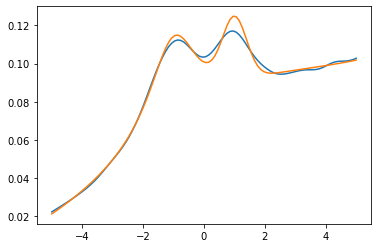

In [66]:
dens = numpy.exp(kde.score_samples(x.reshape(-1,1)))
plt.plot(x, dens, x, pdf)

In [79]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from statsmodels.nonparametric.kde import KDEUnivariate

dens_u = KDEUnivariate(events[:50000])
dens_u.fit(bw=0.3)


In [80]:
dens_u

In [68]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': numpy.linspace(0.1, 10, 11)},
                    cv=3, n_jobs=1) # cross-validation
grid.fit(events[:1000])
print(grid.best_params_)

{'bandwidth': 5.05}


In [74]:
plt.plot(x, dens_u.cdf(x))

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
dens_m = KDEMultivariate(bw=[0.3], data=[events[:50000]], var_type='c') # bw='cv_ml' or 'cv_ls'

In [ ]:
plt.plot(x, dens_m.pdf(x))

In [ ]:
dens_m = KDEMultivariate(bw='cv_ls', data=[events[:50000]], var_type='c') # bw='cv_ml' or 'cv_ls'
dens_m.bw

In [ ]:
plt.plot(x, dens_m.pdf(x))

In [ ]:
lmfit12_03 = model12.fit(dens, params, x=x, fit_kws={'maxfev':1000})

In [ ]:
plt.plot(x, lmfit12_03.best_fit, x, pdf)

In [ ]:
def fit_kde(model, bandwidth, data, x=x, init_params=params):
    """
    Model density of data with kde and subsequently fit model to the kde
    """
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(data)
    dens = numpy.exp(kde.score_samples(x.reshape(-1,1)))
    fit = model.fit(dens, params, x=x, fit_kws={'maxfev':1000})
    return fit

In [ ]:
fit03 = fit_kde(model12, bandwidth=0.3, data=events[:50000])

In [ ]:
fit03.chisqr

In [ ]:
fit03.plot()

In [54]:
help(pandas)

Help on package pandas:

NAME
    pandas

DESCRIPTION
    pandas - a powerful data analysis and manipulation library for Python
    
    **pandas** is a Python package providing fast, flexible, and expressive data
    structures designed to make working with "relational" or "labeled" data both
    easy and intuitive. It aims to be the fundamental high-level building block for
    doing practical, **real world** data analysis in Python. Additionally, it has
    the broader goal of becoming **the most powerful and flexible open source data
    analysis / manipulation tool available in any language**. It is already well on
    its way toward this goal.
    
    Main Features
    -------------
    Here are just a few of the things that pandas does well:
    
      - Easy handling of missing data in floating point as well as non-floating
        point data
      - Size mutability: columns can be inserted and deleted from DataFrame and
        higher dimensional objects
      - Automatic and

In [55]:
from pandas import computation

In [56]:
help(computation)

Help on package pandas.computation in pandas:

NAME
    pandas.computation

PACKAGE CONTENTS
    expressions

FILE
    /Users/thomasholmrod/anaconda3/lib/python3.6/site-packages/pandas/computation/__init__.py




In [58]:
help(pandas.api)

Help on package pandas.api in pandas:

NAME
    pandas.api - public toolkit API

PACKAGE CONTENTS
    types (package)

FILE
    /Users/thomasholmrod/anaconda3/lib/python3.6/site-packages/pandas/api/__init__.py




In [59]:
from pandas import api

In [63]:
from pandas import util